In [1]:
# import numerical libraries
import numpy as np
import scipy.interpolate
import os

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import yaml

# Fklab-python-core tool 
#-----------------------

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# Py-compressed-kde package
# -------------------------

# finally, import the decoding tools
import compressed_kde
from compressed_kde import decode



In [2]:
import mat73
import scipy.io as spio

## load data

In [3]:
path = '../data/'
rec_data = mat73.loadmat(path+'Data4Pset.mat')

In [4]:
rec_data.keys()

dict_keys(['SpikeTimes', 'lfp', 'pos'])

In [5]:
rec_data['pos'].keys()

dict_keys(['data', 'timestamp', 'units'])

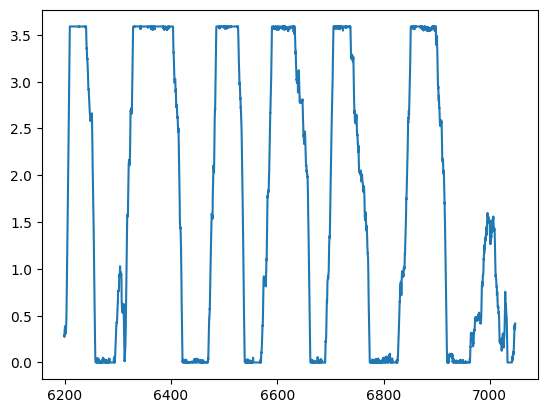

In [6]:
plt.plot(rec_data['pos']['timestamp'], rec_data['pos']['data'])

## building decoder

In [7]:
# amp_threshold = (70.0) # uV, only use spikes with maximum amplitude larger than this threshold
# set kernel bandwidths and compression for encoding
pos_bw = 5  # cm, default spatial kernel bandwidth
#amp_bw = 30.0  # uV, default spike amplitude kernel bandwidth
compression = 0.5 # kernel density compression Mahalanobis distance threshold

# set evaluation grid resolution
#fine_grid_resolution = 2.0
# cm, spatial grid used to build squared distance matrix
#grid_resolution = 4.0
# cm, spatial grid for decoding (should be multiple of fine grid)

# set behavior options
stim_sampling_frequency = 30.0  # Hz, sampling frequency of position tracking
speed_threshold = 15.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

# set decoding options
decode_bin = 0.2  # seconds, bin size for run decoding

In [8]:
def nearest_interp(xi, x, y):
    idx = np.abs(x - xi[:,None])
    return y[idx.argmin(axis=1)]

In [9]:
sp_pos = [nearest_interp(sptimes, rec_data['pos']['timestamp'], rec_data['pos']['data']*100) for sptimes in rec_data['SpikeTimes']]

In [10]:
tt_time = rec_data['SpikeTimes']
tt_pos = sp_pos

In [11]:
# nan_index = np.squeeze(np.argwhere(np.isnan(data['pos']['data']*100)))
# pos_cleaned = np.delete(data['pos']['data']*100, nan_index)
# pos_times_cleaned = np.delete(data['pos']['timestamp'], nan_index)

distance = np.diff(rec_data['pos']['data']*100)
speed = distance / (1/stim_sampling_frequency)

In [12]:
pos = rec_data['pos']['data']*100

In [13]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        abs(speed[:]) > speed_threshold, rec_data['pos']['timestamp'][:]
    )

In [14]:
# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = compressed_kde.EuclideanSpace(
    ["amp{0}".format(x) for x in range(1)]
)

In [15]:
linear_pos_interpolator = scipy.interpolate.interp1d(
    rec_data['pos']['timestamp'], rec_data['pos']['data']*100, kind="nearest", bounds_error=False
)

In [16]:
x = np.linspace(0, 359, 71)

In [17]:
space = compressed_kde.EuclideanSpace(
    ['x'],      # list of labels for all dimensions
    kernel=compressed_kde.GaussianKernel(),  # desired kernel
    bandwidth=[pos_bw]     # list of bandwidths for all dimensions
)
grid = space.grid(
    [x],  # list of coordinate vectors for all dimensions
)

In [18]:
def decoder_build_factory(**kwargs):

    kwd = {
        "stimulus_space",
        "grid",
        "stimulus_duration",
        "compression",
        "stimulus",
        "stimulus_time",
        "event_time",
        "event_stimulus",
        "event_data",
        "event_space",
    }

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # first create a Stimulus object that represents the stimulus probability density
        stim = decode.Stimulus(
            kwargs["stimulus_space"],
            kwargs["grid"],
            kwargs["stimulus_duration"],
            kwargs["compression"],
        )
        stim.add_stimuli(
            kwargs["stimulus"][epochs.contains(kwargs["stimulus_time"])[0]]
        )

        # then build the likelihoods for each of the sources (tetrodes)
        likelihoods = []
        for event_time, event_stimulus in zip(
            kwargs["event_time"], kwargs["event_stimulus"]  # kwargs["event_data"]
        ):
            selection = epochs.contains(event_time)[
                0
            ]  # select events within training epochs
            
            L = decode.PoissonLikelihood(kwargs["event_space"], stim)  # kwargs["event_space"], 
            L.add_events(
                np.concatenate(
                    (event_time.reshape(event_time.shape[0],1)[selection], event_stimulus[selection]), axis=1
                )
            )
            likelihoods.append(L)
            
            '''L = decode.PoissonLikelihood(stim) 
            L.add_events(event_stimulus[selection])
            likelihoods.append(L)'''

        # build decoder from likelihoods
        decoder = decode.Decoder(likelihoods, [])

        return decoder, likelihoods

    return fcn

In [19]:
np.concatenate((tt_time[0].reshape(tt_time[0].shape[0],1), 
                [p.reshape(p.shape[0],1) for p in tt_pos][0]), axis=1
                ).shape

(840, 2)

In [20]:
data = dict(stimulus_space = space,
            grid = grid,
            stimulus_duration = 1./stim_sampling_frequency,
            compression = compression,
            stimulus = pos,
            stimulus_time = rec_data['pos']['timestamp'],
            event_time = tt_time,
            event_data = None,
            event_stimulus = [p.reshape(p.shape[0],1) for p in tt_pos],
            event_space = spike_space,
           )

build_decoder = decoder_build_factory(**data)

In [21]:
def data_build_factory(**kwargs):

    kwd = {"decode_bin", "event_time", "event_data"}

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # split epochs into smaller bins for decoding
        decode_segments = epochs.split(size=kwargs["decode_bin"])
        bins = [
            decode_segments.contains(x, expand=True)[2] for x in kwargs["event_time"]
        ]

        # extract event data for each decoding bin
        data = [
            [
                np.zeros((0, x.shape[1]))
                if len(b[s]) == 1 and b[s][0] == -1
                else x[b[s]]
                for x, b in zip(kwargs["event_time"], bins)
            ]
            for s in range(len(decode_segments))
        ]

        return decode_segments, data

    return fcn

In [22]:
data = dict(decode_bin=decode_bin, event_time=tt_time, event_data=None)

build_data = data_build_factory(**data)

### perform cross-validation

In [23]:
segemnts = [[6199, 6368.8], [6368.8, 6538.6], [6538.6, 6708.4], [6708.4, 6878.2],[6878.2, 7048.]]

In [24]:
trials = fklab.segments.Segment(
   segemnts
)
ntrials = len(trials)

In [25]:
# create lists for collecting real position, estimates and errors
posteriors = []

pos_reals = []
pos_estimates = []
pos_errors = []

dir_reals = []
dir_estimates = []
dir_errors = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data

for test_trial in range(ntrials):
    print(test_trial)

    # set training epochs to all trials except the test trial
    training_epochs = run_epochs.intersection(
        trials[[trial for trial in range(ntrials) if trial != test_trial]]
    )

    # construct decoder for current training epochs
    decoder, likelihoods = build_decoder(training_epochs)

    # test data during run maze arm runs for test trial only
    test_epochs = run_epochs.intersection(trials[test_trial])

    # extract event data for each time bin
    decode_segments, data = build_data(test_epochs)

    # perform decoding and concatenate posteriors
    posterior = [decoder.decode(x, decode_bin, True) for x in data]
    posterior = np.vstack(posterior)
    posteriors.append(posterior)

    # compute MAP estimates
    '''n, shape = posterior.shape[0], posterior.shape[1:]
    max_posterior = np.unravel_index(
        np.argmax(posterior.reshape((n, -1)), axis=1), shape
    )
    max_posterior = np.column_stack(max_posterior)
    # max_posterior = np.unravel_index( np.argmax(posterior, axis=1), grid.shape )
    pos_estimates.append(circular_grid.points()[max_posterior[:, 0]])
    dir_estimates.append(max_posterior[:, 1])
    
    # determine real stimulus values
    pos_reals.append(linear_pos_interpolator(decode_segments.center))
    dir_reals.append(linear_rd_interpolator(decode_segments.center))

    # compute errors
    pos_errors.append(
        np.abs(
            maze["maze"]["shapes"]["track"]["shape"].distance(
                pos_estimates[-1], pos_reals[-1]
            )
        )
    )
    dir_errors.append(dir_estimates[-1] != dir_reals[-1])'''
    
'''pos_estimates = np.concatenate(pos_estimates)
pos_reals = np.concatenate(pos_reals)
# pos_errors = np.concatenate(pos_errors)

dir_estimates = np.concatenate(dir_estimates)
dir_reals = np.concatenate(dir_reals)
dir_errors = np.concatenate(dir_errors)'''

0
1
2
3
4


'pos_estimates = np.concatenate(pos_estimates)\npos_reals = np.concatenate(pos_reals)\n# pos_errors = np.concatenate(pos_errors)\n\ndir_estimates = np.concatenate(dir_estimates)\ndir_reals = np.concatenate(dir_reals)\ndir_errors = np.concatenate(dir_errors)'

In [26]:
len(posteriors)

5

In [27]:
posteriors[0].shape

(123, 71)

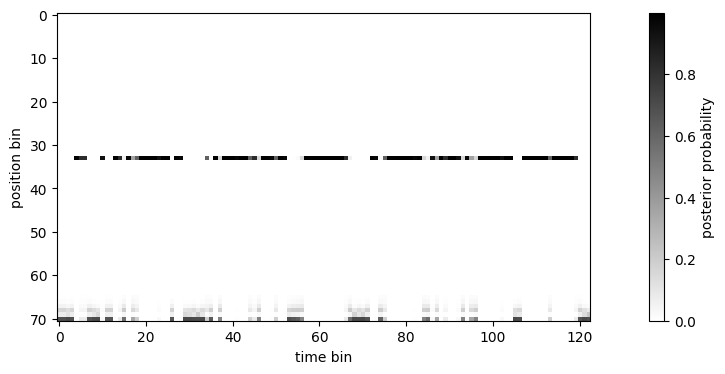

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[0].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");